In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pymc
import xarray as xr
import arviz as az

# A small Bayesian Analysis

The [Michaelis-Menten kinetics](https://en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics) is the simplest model of a enzyme-catalyzed reaction. It maps the substrate concentration $c$ to the reaction rate $v$ by
$$ v(c) = v_\text{max} \cdot \frac{c}{K_m + c}$$
$v_\text{max}$ and $K_m$ are enzyme-specific parameters, both constrained to $(0, \infty)$. We will use the Michaelis-Menten model to infer these parameters from generated reaction rates.

### Setup

Execute the cell below to generate the data for this exercise.

In [2]:
def michaelis_menten(v_max, k_m, c):
    return v_max * c / (k_m + c)

v_max = 1.
k_m = 0.1

n = 10
sigma = 1e-1
c = np.power(10, np.linspace(-3, 1, num=n))
v = michaelis_menten(v_max, k_m, c) + np.random.normal(loc=0, scale=sigma)

### Explore the data

- Plot substrate data `c` against the "measured" reaction rates `v`. Explain what is going on in terms of substrate concentration and enzyme activity.
- Try using different values for `v_max` and `k_m`. Explain how they effect the generated data.

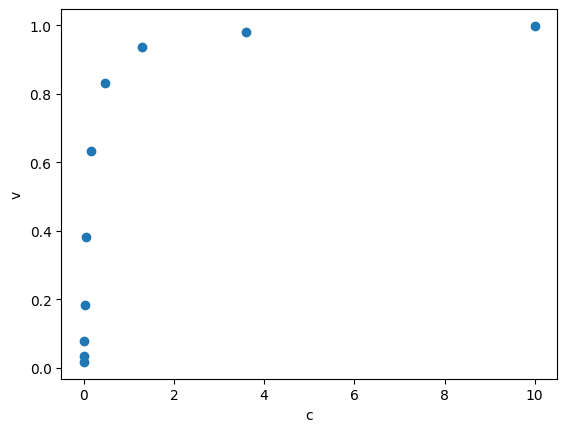

In [3]:
plt.scatter(c, v)
plt.xlabel("c")
plt.ylabel("v")
plt.show()

### Select appropriate priors

Experiment to find suitable priors. Remember, that both parameters have lower bounds which needs to be reflected in the choice of prior. Execute the prior predictive check below. Because you don't have any particular knowledge, avoid too informative priors. You can assume, however, that you are sure about magnitude of the measurement values.

You will now start to use `pymc`, a software for Bayesian Inference, and MCMC. In `pymc`, model variables are specified by their prior, e.g. 
`var_name = pymc.Normal("variable name", 0, 1)`.

Some inspiration:
- [Half normal](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.HalfNormal.html) (prefers close to zero values) or [Log normal](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.LogNormal.html) distributions (probablity mass peak can be shifted)
- [Bound transformation](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.distributions.transforms.Interval.html#pymc.distributions.transforms.Interval) for any [continuous distribution](https://www.pymc.io/projects/docs/en/latest/api/distributions/continuous.html)
- [Half flat](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.HalfFlat.html) distribution (least informative choice, but is improper and you can't do prior predictive checks)

In [4]:
with pymc.Model() as model:
    # Priors
    v_max_rv = pymc.LogNormal("v_max", 0, 0.25) # e.g.: pymc.Uniform("v_max", 0, 1)
    k_m_rv = pymc.LogNormal("k_m", 0, 1)
    
    # Likelihood
    v_rv = michaelis_menten(v_max_rv, k_m_rv, c)
    pymc.Normal("obs", mu=v_rv, sigma=sigma, observed=v)

In [5]:
with model:
    trace = pymc.sample_prior_predictive(samples=100)

Sampling: [k_m, obs, v_max]


In [6]:
c_pred = xr.DataArray(np.linspace(1e-3, 10, num=1000))
v_pred = michaelis_menten(trace.prior["v_max"], 
                          trace.prior["k_m"],
                          c_pred)

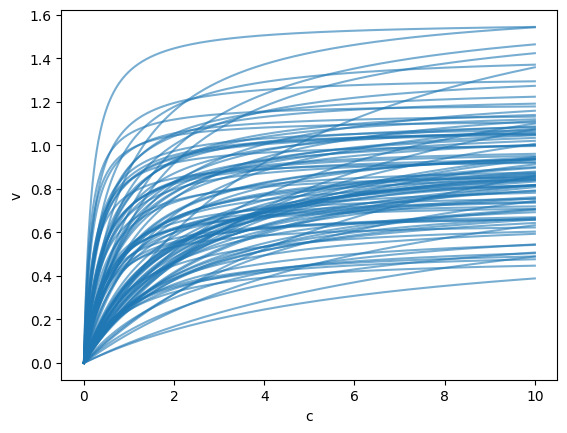

In [7]:
plt.plot(c_pred, v_pred.stack(sample=("chain", "draw")), color="tab:blue", alpha=0.6)
plt.xlabel("c")
plt.ylabel("v")
plt.show()

### Obtaining the posterior: MCMC sampling

The next step is infering the posterior by MCMC. This can be easily done by `pymc` with the `pymc.sample` command. Look at the posterior plot. Are the results sensible?

In [ ]:
with model:
    trace = pymc.sample(500, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [ ]:
pymc.plot_posterior(trace)
plt.show()

### Posterior Predictive Checks

Posterior predictive checks can also be done easily by `pymc`. Run the code below code. Would you accept the results of the analysis?

In [ ]:
with model:
    pymc.sample_posterior_predictive(trace, extend_inferencedata=True)

In [ ]:
c_pred = xr.DataArray(np.linspace(1e-3, 10, num=1000))
v_pred = michaelis_menten(trace.posterior["v_max"], 
                          trace.posterior["k_m"],
                          c_pred)

In [ ]:
plt.plot(c_pred, v_pred.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6)
az.plot_hdi(c, trace.posterior_predictive["obs"])
plt.scatter(c, trace.observed_data["obs"])
plt.xlabel("c")
plt.ylabel("v")
plt.show()